In [1]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as stats
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import sys

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
df = pd.read_csv("default of credit card clients.csv")
data = df.drop('Y', axis=1)
labels = df[['Y']]

In [4]:
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data = torch.tensor(data.values).float()
labels = torch.tensor(labels.values).float()

#X = data
#y = labels

In [5]:
trainsize = 0.75
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=trainsize)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

In [6]:
batchsize = 8192
# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=batchsize, shuffle=True, drop_last=False)

In [7]:
print(len(train_loader))


3


In [8]:
def createANNmodel():

  # model architecture
  ANN = nn.Sequential(
      nn.Linear(23,64),  # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),        # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),        # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),        # activation unit
      nn.Linear(64,1),   # output unit
      #nn.Sigmoid(),     # final activation unit
      nn.ReLU(),
        )

  # loss function
  lossfun = nn.BCELoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(ANN.parameters(),lr=0.1)

  # model output
  return ANN,lossfun,optimizer

In [9]:
# Define a global parameter 'numepochs' with a value of 500, representing the number of training epochs.
numepochs = 200

# Define a function 'trainTheModel' to train the neural network.
def trainTheModel():

  # Initialize lists to store training and test accuracies, as well as losses during training.
  trainAcc = []
  testAcc  = []
  losses   = []

  # Loop over epochs (training iterations).
  for epochi in range(numepochs):
    
    if epochi % 100 == 0:
        print(epochi)
    # Activate training mode for the neural network.
    ANN.train()

    # Initialize lists to store accuracy and loss for each batch during training.
    batchAcc  = []
    batchLoss = []

    # Loop over training data batches.
    for X,y in train_loader:

      # Perform a forward pass through the neural network.
      yHat = ANN(X)
      #print(yHat)
      # Calculate the loss using the specified loss function.
      loss = lossfun(yHat,y)
      
      # Clear previous gradient calculations.
      optimizer.zero_grad()
      
      # Perform backpropagation to compute gradients.
      loss.backward()
      
      # Update the model's parameters using the optimizer.
      optimizer.step()

      # Compute training accuracy for this batch and append to 'batchAcc'.
      #batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchAcc.append( 100*torch.mean(((yHat.round()) == y).float()) )
      
      # Append the loss value for this batch to 'batchLoss'.
      batchLoss.append( loss.item() )
    # End of batch loop...

    # Calculate the average training accuracy for this epoch and append to 'trainAcc'.
    trainAcc.append( np.mean(batchAcc) )

    # Append the average loss for this epoch to 'losses'.
    losses.append( np.mean(batchLoss) )

    # Test accuracy on the validation set.
    
    # Extract X,y from the test dataloader.
    X,y = next(iter(test_loader))

    # Activate evaluation mode (no gradient computation) for the neural network.
    ANN.eval()

    # Perform forward pass for the test data.
    with torch.no_grad():
      #predictions = torch.argmax( ANN(X),axis=1 )
      predictions = ANN(X)
      #print(predictions)
    
    # Compute accuracy on the test data and append to 'testAcc'.
    #testAcc.append( 100*torch.mean((predictions == y).float()).item() )
    testAcc.append( 100*torch.mean(((predictions.round()) == y).float()) )
    #rint(predictions)
    
  
  # Function output: training accuracies, test accuracies, and losses over epochs.
  return trainAcc, testAcc, losses

In [10]:
# Create a new model, loss function, and optimizer.
ANN, lossfun, optimizer = createANNmodel()
# Train the model using the current batch size.
trainAcc, testAcc, losses = trainTheModel()


0
100


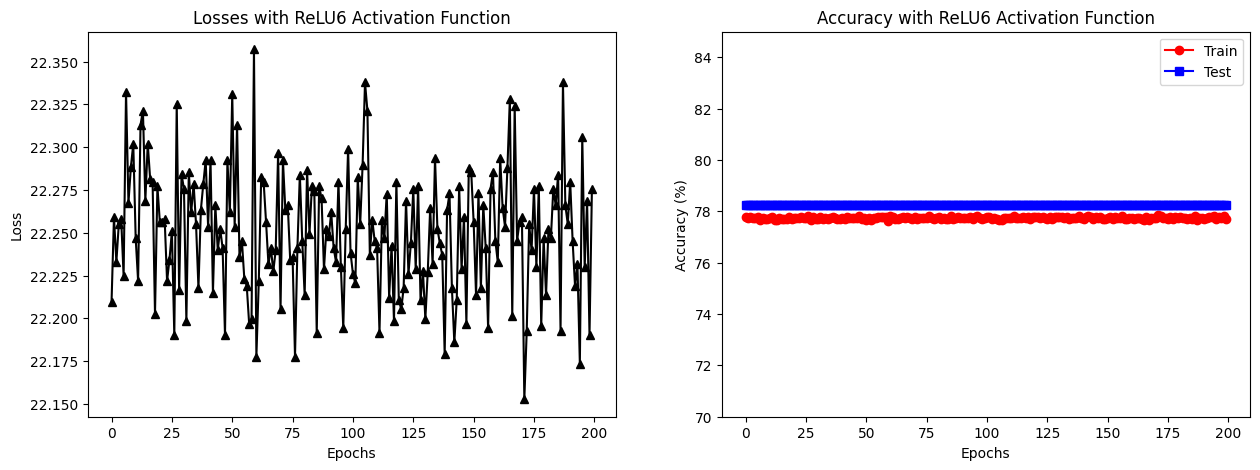

In [11]:


# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with ReLU6 Activation Function')

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with ReLU6 Activation Function')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([70,85])

plt.show()

In [12]:
print("Training accuracy: " + str(trainAcc[199]))

Training accuracy: 77.72037


In [13]:
print("Testing accuracy: " + str(testAcc[199]))

Testing accuracy: tensor(78.2667)
